In [1]:
import collections
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import tqdm

import ase.data
import dscribe
import matminer
import pymatgen.core.composition
import pymatgen.io.ase
from pymatgen.analysis.local_env import JmolNN

from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers.structure.misc import EwaldEnergy
from matminer.featurizers.structure.order import StructuralComplexity
from matminer.featurizers.structure.symmetry import GlobalSymmetryFeatures
from matminer.featurizers.structure.bonding import GlobalInstabilityIndex
from matminer.featurizers.site.bonding import AverageBondLength

import pandas as pd
import swifter

RANDOM_SEED = 1234

pd.options.mode.chained_assignment = None
tqdm.tqdm.pandas()
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Data Cleaning

In [2]:
df = pd.read_pickle("../../raw_data/2d_mat_dataset_raw.pkl")
total = len(df)
print(f"Starting with {total} entries. Includes top-down and bottom-up.")
      
# Throw out systems that are predicted to decompose
df = df[df["decomposition_energy (eV/atom)"] == 0]
print(f"Discarding {total-len(df)} entries predicted to decompose (Decomp energy != 0). Total is now {len(df)}.")
total = len(df)

# Remove systems containing f-block / synthetic elements
fblock_and_synth = ["La", "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu",
                    "Ac", "Th", "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr",
                    "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Tg", "Cn", "Nh", "Fl", "Mc", "Mc", "Lv", "Ts", "Og"]
df = df[df["atoms_object (unitless)"].apply(
           lambda atoms: all(symbol not in fblock_and_synth for symbol in atoms.get_chemical_symbols()))
       ]
print(f"Discarding {total - len(df)} entries in the f-block, or synthetics. Total is now {len(df)}.")
total = len(df)

# Discard metallic systems
df = df[df["bandgap (eV)"] > 0.1]
print(f"Discarding {total - len(df)} entries that are metallic. Total is now {len(df)}.")
total = len(df)

# To keep the methodology consistent, discard systems where a U-correction was applied
df = df[df["is_hubbard (unitless)"] == False]
print(f"Discarding {total - len(df)} entries that have U-corrections applied (metal oxides/fluorides). Total is now {len(df)}.")
total = len(df)

# Discard top-down materials
df = df[df["discovery_process (unitless)"] == 'top-down']
print(f"Discarding {total - len(df)} bottom-up materials. Total is now {len(df)}.")
total = len(df)

# Throw out systems based on exfoliation energy
min_exfol = 0.0
max_exfol = 0.2
df = df[df["exfoliation_energy_per_atom (eV/atom)"].apply(lambda exfol: min_exfol < exfol <= max_exfol)]
print(f"Discarding {total - len(df)} entries outside {np.round(min_exfol,3)} < exfoliation energy <= {np.round(max_exfol,3)}. "
      f"Total is now {len(df)}.")

Starting with 6351 entries. Includes top-down and bottom-up.
Discarding 5606 entries predicted to decompose (Decomp energy != 0). Total is now 745.
Discarding 135 entries in the f-block, or synthetics. Total is now 610.
Discarding 155 entries that are metallic. Total is now 455.
Discarding 25 entries that have U-corrections applied (metal oxides/fluorides). Total is now 430.
Discarding 131 bottom-up materials. Total is now 299.
Discarding 38 entries outside 0.0 < exfoliation energy <= 0.2. Total is now 261.


# Featurization

In [3]:
structures = df['atoms_object (unitless)'].apply(pymatgen.io.ase.AseAtomsAdaptor.get_structure)
df['ox_struct'] = structures.apply(lambda i: i.copy())

# struct.add_oxidation_state_by_guess() modifies the structure in-place
df.ox_struct.swifter.apply(lambda struct: struct.add_oxidation_state_by_guess())

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

3006    None
3014    None
3019    None
3043    None
3052    None
        ... 
5810    None
5817    None
5825    None
5909    None
5911    None
Name: ox_struct, Length: 261, dtype: object

In [4]:
struct_features = MultipleFeaturizer([
    EwaldEnergy(),
    StructuralComplexity(),
    GlobalSymmetryFeatures('n_symmetry_ops'),
])
df[struct_features.feature_labels()] = struct_features.featurize_many(df.ox_struct).copy()

MultipleFeaturizer:   0%|          | 0/261 [00:00<?, ?it/s]

In [5]:
desc = GlobalInstabilityIndex()

def maybe_global_instability(struct):
    try:
        return desc.featurize(struct)[0]
    except:
        return None

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df['global_instability'] = df.ox_struct.swifter.apply(maybe_global_instability).copy()

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

In [6]:
neighbor_finder = JmolNN()

def average_bond_length(structure, featurizer = AverageBondLength(neighbor_finder)):
    n_atoms = len(structure)
    try:
        lengths = map(lambda i: featurizer.featurize(structure, i)[0], range(n_atoms))
        return sum(lengths) / n_atoms
    except IndexError:
        return None

df['bond_length_average'] = df.ox_struct.swifter.apply(average_bond_length).copy()

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

In [7]:
from matminer.featurizers.site.bonding import AverageBondAngle

def average_bond_angle(structure, featurizer = AverageBondAngle(neighbor_finder)):
    n_atoms = len(structure)
    try:
        angles = map(lambda i: featurizer.featurize(structure, i)[0], range(n_atoms))
        return sum(angles) / n_atoms
    except IndexError:
        return None
df['bond_angle_average'] = df.ox_struct.swifter.apply(average_bond_angle).copy()

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/matminer/featurizers/site/bonding.py:250: RuntimeWarning: All-NaN slice encountered
  minimum_bond_angles = np.nanmin(bond_angles, axis=1)


In [8]:
def average_cn(structure, neighbor_finder = neighbor_finder):
    n_atoms = len(structure)
    cns = map(lambda i: neighbor_finder.get_cn(structure, i), range(n_atoms))
    return sum(cns) / n_atoms
df['average_cn'] = df.ox_struct.swifter.apply(average_cn).copy()

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

In [9]:
def ab_perimeter_area_ratio(structure):
    a, b, c = structure.lattice.matrix
    perimeter = 2*np.linalg.norm(a) + 2*np.linalg.norm(b)
    area = np.linalg.norm(np.cross(a,b))
    return perimeter / area
df['perimeter_area_ratio'] = df.ox_struct.swifter.apply(ab_perimeter_area_ratio).copy()

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

In [10]:
def slab_thickness(structure:ase.Atoms):
    """
    For all atoms in the cell, will get the covalent raius of the atom and add (or subtract) this with the position.
    The maximum (from adding) and minimum (from subtracting) the radius from the position is used to define the slab's borders.
    The highest and lowest point of the slab are used to determine thickness.
    """
    structure = structure.copy()
    
    positions = structure.get_scaled_positions()
    
    in_target_zone = all(map(lambda pos: 0.25 < pos < 0.75, positions[:,2]))
    max_iter = 10000
    count = 0
    while not in_target_zone:
        delta_c = 0.01
        structure.translate([0,0,delta_c])
        in_target_zone = all(map(lambda pos: 0.25 < pos < 0.75, structure.get_scaled_positions()[:,2]))
        count += 1
        assert count < max_iter
    
    c_pos = structure.get_scaled_positions()[:,2] * structure.cell.lengths()[2]
    radii = ase.data.covalent_radii[structure.get_atomic_numbers()]
        
    thickness = max(c_pos + radii) - min(c_pos - radii)
    
    return thickness

df["slab_thickness"] = df["atoms_object (unitless)"].swifter.apply(slab_thickness)

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

In [11]:
# Get max atoms, which controls the size of the N x N coulomb matrix
max_atoms = max(df["atoms_object (unitless)"].apply(lambda atoms: len(atoms)))

matrix = dscribe.descriptors.CoulombMatrix(n_atoms_max = max_atoms,
                                           permutation = 'eigenspectrum',
                                           flatten = True)

coulomb_cols = df['atoms_object (unitless)'].swifter.apply(matrix.create)
new_cols = coulomb_cols[coulomb_cols.index[0]]
for i in coulomb_cols[coulomb_cols.index[1:]]:
    # Gets turned into a complex number, but all imaginary parts are 0 for these systems
    new_cols = np.vstack([new_cols, i]).real

for col in range(max_atoms):
    colname = f"coulomb_eigenspectrum_{col}"
    df[colname] = new_cols[:, col]

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

In [12]:
df["formula"] = df["atoms_object (unitless)"].swifter.apply(lambda atoms: atoms.get_chemical_formula(empirical=True))

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

In [13]:
df.to_pickle("all_descriptors.pkl")

object_cols = ["atoms_object (unitless)",
               "ox_struct"]

regression_irrelevant = object_cols + [
    'discovery_process (unitless)',
    'potcars (unitless)',
    'is_hubbard (unitless)',
    'energy_per_atom (eV)',
    'decomposition_energy (eV/atom)',
    'is_bandgap_direct (unitless)',
    'is_metal (unitless)',
    'energy_vdw_per_atom (eV/atom)',
    'total_magnetization (Bohr Magneton)']

df.drop(columns=object_cols).to_csv("both_extra_descriptors.csv")

# Chemical Info

In [14]:
for allowed_symbols, set_name in [
    [["N"], "nitrides"],
    [["O"], "oxides"],
    [["S"], "sulfides"],
    [["C"], "carbides"],
    [["F", "Cl", "Br", "Cl"], "halides"],
    [["O", "S", "Se", "Te"], "chalcogens"],
    [["N", "O", "As", "Sb"], "pnictogens"],
    [["Al", "Ga", "Ge", "In", "Sn", "Sb", "Tl", "Pb", "Bi", "Po"], "pBlockMetals"]
]:
    fun = lambda atoms: any(symbol in allowed_symbols for symbol in atoms.get_chemical_symbols())
    filtered = df[df["atoms_object (unitless)"].swifter.apply(fun)]
    filtered.drop(columns=object_cols).to_csv(f"both_{set_name}Only.csv")

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

In [15]:
# Based on https://en.wikipedia.org/wiki/Wide-bandgap_semiconductor and https://www.kymatech.com/about/faqs/429-what-is-an-ultra-wide-bandgap-semiconductor-material
df[df["bandgap (eV)"].swifter.apply(lambda bg: 0 < bg < 2)].drop(columns=object_cols).to_csv("both_conventionalSemiconductorsOnly.csv")
df[df["bandgap (eV)"].swifter.apply(lambda bg: 2 <= bg <= 3.4)].drop(columns=object_cols).to_csv("both_WBGOnly.csv")
df[df["bandgap (eV)"].swifter.apply(lambda bg: 3.4 < bg < 10)].drop(columns=object_cols).to_csv("both_UWBGOnly.csv")

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

In [16]:
import sklearn.model_selection

data_train, data_test = sklearn.model_selection.train_test_split(df.drop(columns=regression_irrelevant + ['formula', '2dm_id (unitless)', 'exfoliation_energy_per_atom (eV/atom)']), test_size=0.1, random_state=RANDOM_SEED)

train_x = data_train.drop(columns="bandgap (eV)").to_numpy().astype(np.float64)
train_y = data_train["bandgap (eV)"].to_numpy()

test_x = data_test.drop(columns="bandgap (eV)").to_numpy().astype(np.float64)
test_y = data_test["bandgap (eV)"].to_numpy()

# Stacked Ensemble
Tried out a stacked ensemble approach below, got decent results compared to TPOT.
Imputation -> Standardization -> PCA -> Ensemble

Ensemble contains LASSO, Ridge, Support Vector Regression, Gradient-Boosted Trees, and a basic Neural Network. The ensemble's generalizer is a kernel ridge regressor.

In [17]:
import sklearn.ensemble
import sklearn.impute
import sklearn.pipeline
import sklearn.linear_model
import sklearn.kernel_ridge
import sklearn.gaussian_process
import sklearn.decomposition
import sklearn.svm
import sklearn.neural_network

import optuna

from sklearn.experimental import enable_hist_gradient_boosting

import optuna

best_model = None
model = None

def model_callback(study, trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

def objective(trial: optuna.Trial):
    global model
    
    model = sklearn.pipeline.Pipeline(
        [("Imputation", sklearn.impute.KNNImputer(n_neighbors=trial.suggest_int('KNN_imputation_n_neighbors', 2, 10))),
         ("Scaler", sklearn.preprocessing.StandardScaler()),
         ("PCA", sklearn.decomposition.PCA(n_components=trial.suggest_int("pca_n_dimensions", 2, 150))),
         ("StackedEnsemble", sklearn.ensemble.StackingRegressor(
             estimators = [
                 ('Lasso', sklearn.linear_model.LassoCV(tol=0.001)),
                 ('Ridge', sklearn.linear_model.RidgeCV()),
                 ('SVR', sklearn.svm.SVR(kernel=trial.suggest_categorical('SVR_Kernel', ['linear', 'poly', 'rbf']),
                                         gamma='auto',
                                         C=trial.suggest_uniform('SVR_C', 0.1, 10),
                                         epsilon=trial.suggest_uniform('SVR_epsilon', 0.01, 1))),
                 ('GB', sklearn.ensemble.GradientBoostingRegressor(n_estimators=trial.suggest_int('GB_n_estimators', 10,1000))),
                 ('NN', sklearn.neural_network.MLPRegressor([trial.suggest_int('NN_Hidden1_Dims', 2, 200),
                                                             trial.suggest_int('NN_Hidden2_Dims', 2, 200)],
                                                             max_iter=1000)),
             ],
             final_estimator=sklearn.kernel_ridge.KernelRidge(),
             cv=2,
             n_jobs=2)),
         ]
    )
    score = sklearn.model_selection.cross_val_score(model, train_x, train_y, scoring='neg_mean_squared_error', cv=4).mean()
    return score
    
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=32, n_jobs=2, callbacks=[model_callback])

[I 2021-07-20 17:21:42,829] A new study created in memory with name: no-name-3cbd478c-9e9a-4e96-92ca-31c04e6c5ef8
[I 2021-07-20 17:21:51,404] Trial 0 finished with value: -1.0380843777537638 and parameters: {'KNN_imputation_n_neighbors': 3, 'pca_n_dimensions': 21, 'SVR_Kernel': 'poly', 'SVR_C': 7.9011773514084025, 'SVR_epsilon': 0.07345284900123933, 'GB_n_estimators': 496, 'NN_Hidden1_Dims': 27, 'NN_Hidden2_Dims': 128}. Best is trial 0 with value: -1.0380843777537638.
[I 2021-07-20 17:21:51,927] Trial 1 finished with value: -0.9285726344805425 and parameters: {'KNN_imputation_n_neighbors': 8, 'pca_n_dimensions': 11, 'SVR_Kernel': 'rbf', 'SVR_C': 9.928101129771393, 'SVR_epsilon': 0.1569100994385063, 'GB_n_estimators': 377, 'NN_Hidden1_Dims': 165, 'NN_Hidden2_Dims': 159}. Best is trial 1 with value: -0.9285726344805425.
[I 2021-07-20 17:22:01,831] Trial 2 finished with value: -1.3578589599481283 and parameters: {'KNN_imputation_n_neighbors': 6, 'pca_n_dimensions': 2, 'SVR_Kernel': 'rbf',

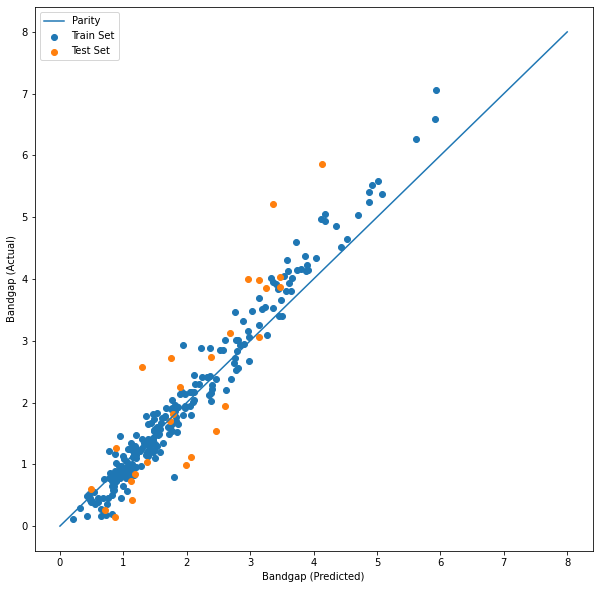

In [22]:
model = best_model
model.fit(X=train_x, y=train_y)
train_y_pred = model.predict(train_x)
test_y_pred = model.predict(test_x)

plt.rcParams['figure.figsize'] = [10,10]

plt.scatter(x=train_y_pred, y=train_y, label="Train Set")
plt.scatter(x=test_y_pred, y=test_y, label="Test Set")
plt.plot([0,8], [0,8], label="Parity")
plt.ylabel("Bandgap (Actual)")
plt.xlabel("Bandgap (Predicted)")
plt.legend()

In [23]:
import sklearn.metrics  
print("Test-Set Error Metrics:")
for name, metric in [
    ["MAE", sklearn.metrics.mean_absolute_error],
    ["MAPE", sklearn.metrics.mean_absolute_percentage_error],
    ["MSE", sklearn.metrics.mean_squared_error],
    ["R2", sklearn.metrics.r2_score],
    ["Max Error", sklearn.metrics.max_error]
]:
    print(f"{name}: {np.round(metric(y_true=test_y, y_pred=test_y_pred), 4)}")


Test-Set Error Metrics:
MAE: 0.6505
MAPE: 0.5939
MSE: 0.631
R2: 0.7316
Max Error: 1.8543


In [24]:
import sklearn.metrics  

all_data = df.drop(columns=regression_irrelevant + ['formula', '2dm_id (unitless)', 'exfoliation_energy_per_atom (eV/atom)'])

all_x = all_data.drop(columns="bandgap (eV)").to_numpy().astype(np.float64)
all_y = all_data["bandgap (eV)"].to_numpy()

n_samples = len(all_data)

metrics = {"MAE": sklearn.metrics.mean_absolute_error,
           "MAPE": sklearn.metrics.mean_absolute_percentage_error,
           "MSE": sklearn.metrics.mean_squared_error,
           "R2": sklearn.metrics.r2_score,
           "Max Error": sklearn.metrics.max_error}
metrics = dict((key, sklearn.metrics.make_scorer(value)) for key, value in metrics.items())
 
cv=5
scores = sklearn.model_selection.cross_validate(model, X=all_x, y=all_y, cv=cv, scoring=metrics, verbose=2, n_jobs=4)
print(f"{cv}-fold Error Metrics:")
for name, score in scores.items():
    if name in ['fit_time', 'score_time']:
        continue
    print(f"{name[5:]}: {np.round(np.mean(score), 4)}")

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


5-fold Error Metrics:
MAE: 0.7148
MAPE: 0.6391
MSE: 1.0435
R2: 0.4374
Max Error: 3.2015


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   18.0s finished


# TPOT
Tested TPOT below

In [31]:
import tpot
model = tpot.TPOTRegressor(
    generations=None,
    population_size=100,
    max_eval_time_mins=10/60,
    max_time_mins=5,
    cv=2,
    verbosity=2,
    scoring="neg_mean_squared_error",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=4,
    random_state=RANDOM_SEED
)
model.fit(features=train_x, target=train_y)

Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]

Traceback (most recent call last):
  File "/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/stopit/utils.py", line 145, in wrapper
    result = func(*args, **kwargs)
  File "/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/tpot/decorators.py", line 57, in time_limited_call
    func(*args)
  File "/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py", line 1008, in fit
    return super().fit(X, y, sample_weight)
  File "/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py", line 130, in fit
    sample_weight, estimator_weight, estimator_error = self._boost(
  File "/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py", line 1069, in _boost
    estimator.fit(X_, y_)
  Fil


Generation 1 - Current best internal CV score: -0.8462024103089665

Generation 2 - Current best internal CV score: -0.8462024103089665

Generation 3 - Current best internal CV score: -0.8462024103089665


Traceback (most recent call last):
  File "/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/stopit/utils.py", line 145, in wrapper
    result = func(*args, **kwargs)
  File "/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/tpot/decorators.py", line 57, in time_limited_call
    func(*args)
  File "/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py", line 1008, in fit
    return super().fit(X, y, sample_weight)
  File "/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py", line 130, in fit
    sample_weight, estimator_weight, estimator_error = self._boost(
  File "/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py", line 1070, in _boost
    y_predict = estimator.predi


Generation 4 - Current best internal CV score: -0.8462024103089665

5.70 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.3, min_samples_leaf=2, min_samples_split=11, n_estimators=100)


TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

Imputing missing values in feature set
Imputing missing values in feature set


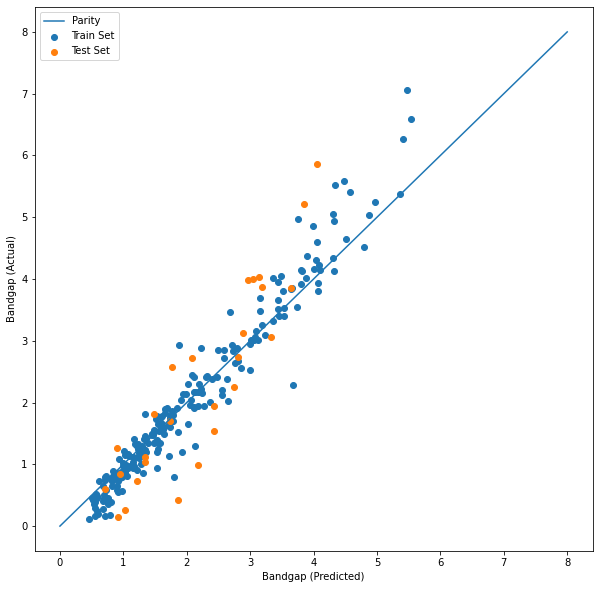

In [32]:
train_y_pred = model.predict(train_x)
test_y_pred = model.predict(test_x)

plt.rcParams['figure.figsize'] = [10,10]

plt.scatter(x=train_y_pred, y=train_y, label="Train Set")
plt.scatter(x=test_y_pred, y=test_y, label="Test Set")
plt.plot([0,8], [0,8], label="Parity")
plt.ylabel("Bandgap (Actual)")
plt.xlabel("Bandgap (Predicted)")
plt.legend()

In [33]:
import sklearn.metrics  
print("Test-Set Error Metrics:")
for name, metric in [
    ["MAE", sklearn.metrics.mean_absolute_error],
    ["MAPE", sklearn.metrics.mean_absolute_percentage_error],
    ["MSE", sklearn.metrics.mean_squared_error],
    ["R2", sklearn.metrics.r2_score],
    ["Max Error", sklearn.metrics.max_error]
]:
    print(f"{name}: {np.round(metric(y_true=test_y, y_pred=test_y_pred), 4)}")


Test-Set Error Metrics:
MAE: 0.6278
MAPE: 0.6786
MSE: 0.5992
R2: 0.7451
Max Error: 1.8111


**Important Note:** In the first iteration of this notebook, we incorrectly named the coulomb eigenspectrum the "SOAP Eigenspectrum." If we re-run the notebook, should fix that. The point of the below variable importances is that the model chosen by TPOT generally does not select the Coulomb Matrix Eigenspectrum.

In [50]:
importances = list(zip(data_train.drop(columns='bandgap (eV)').columns, model.fitted_pipeline_[0].feature_importances_))
[i for i in list(reversed(sorted(importances, key=lambda i: i[1]))) if i[0].startswith("coulomb")]

[('soap_eigenspectrum_0', 0.0012682728287910809),
 ('soap_eigenspectrum_1', 0.0010859603399182725),
 ('soap_eigenspectrum_2', 0.0006445210863782394),
 ('soap_eigenspectrum_4', 0.0006262616144143134),
 ('soap_eigenspectrum_35', 0.0005797345246574924),
 ('soap_eigenspectrum_8', 0.0005076739088171631),
 ('soap_eigenspectrum_34', 0.0004736166342690544),
 ('soap_eigenspectrum_9', 0.00040206362508192137),
 ('soap_eigenspectrum_11', 0.000359654329890164),
 ('soap_eigenspectrum_5', 0.0002747666354408463),
 ('soap_eigenspectrum_3', 0.0002685782494326702),
 ('soap_eigenspectrum_10', 0.0002392692536962885),
 ('soap_eigenspectrum_7', 0.0002195973953006403),
 ('soap_eigenspectrum_32', 0.00020026417689176265),
 ('soap_eigenspectrum_33', 0.00016070547206602416),
 ('soap_eigenspectrum_24', 0.00014825643681490948),
 ('soap_eigenspectrum_26', 0.00011110171723152402),
 ('soap_eigenspectrum_27', 0.00010977143440579484),
 ('soap_eigenspectrum_15', 0.00010274782734979073),
 ('soap_eigenspectrum_17', 0.00010

# TPOT Without XenonPy
Re-ran TPOT for a few minutes, without any XenonPy descriptors (those containing a colon in the name).
Not enough information when we remove these columns. Does not generalize well.

In [57]:
to_drop = [col for col in data_train.columns if ":" in col]

n_data_train, n_data_test = sklearn.model_selection.train_test_split(df.drop(columns=regression_irrelevant + to_drop + ['formula', '2dm_id (unitless)', 'exfoliation_energy_per_atom (eV/atom)']), test_size=0.1, random_state=RANDOM_SEED)

n_train_x = n_data_train.drop(columns="bandgap (eV)").to_numpy().astype(np.float64)
n_train_y = n_data_train["bandgap (eV)"].to_numpy()

n_test_x = n_data_test.drop(columns="bandgap (eV)").to_numpy().astype(np.float64)
n_test_y = n_data_test["bandgap (eV)"].to_numpy()

In [58]:
import tpot
n_model = tpot.TPOTRegressor(
    generations=None,
    population_size=100,
    max_eval_time_mins=10/60,
    max_time_mins=5,
    cv=2,
    verbosity=2,
    scoring="neg_mean_squared_error",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=4,
    random_state=RANDOM_SEED
)
n_model.fit(features=n_train_x, target=n_train_y)

Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1.1237930862653016

Generation 2 - Current best internal CV score: -1.1231950059160558

Generation 3 - Current best internal CV score: -1.0807338603593737

Generation 4 - Current best internal CV score: -1.0805096386554882

Generation 5 - Current best internal CV score: -1.0805096386554882

Generation 6 - Current best internal CV score: -1.0415556363488772

Generation 7 - Current best internal CV score: -1.0415556363488772


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBRegressor(LinearSVR(input_matrix, C=15.0, dual=False, epsilon=1.0, loss=squared_epsilon_insensitive, tol=0.0001), learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.8, verbosity=0)


TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

Imputing missing values in feature set
Imputing missing values in feature set


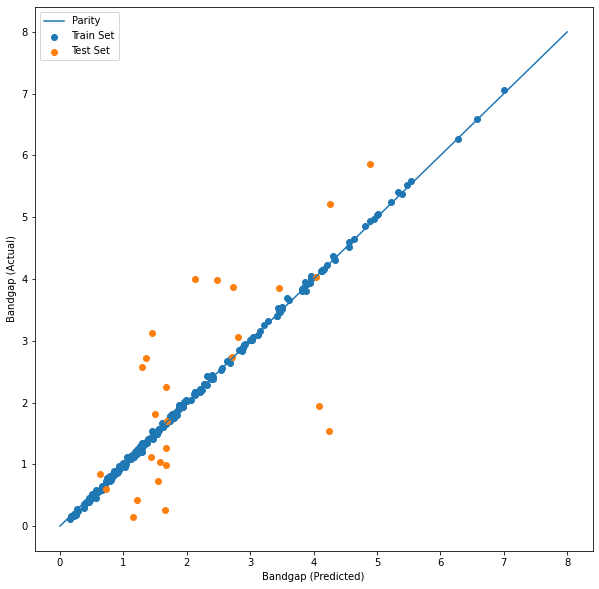

In [60]:
n_train_y_pred = n_model.predict(n_train_x)
n_test_y_pred = n_model.predict(n_test_x)

plt.rcParams['figure.figsize'] = [10,10]

plt.scatter(x=n_train_y_pred, y=n_train_y, label="Train Set")
plt.scatter(x=n_test_y_pred, y=n_test_y, label="Test Set")
plt.plot([0,8], [0,8], label="Parity")
plt.ylabel("Bandgap (Actual)")
plt.xlabel("Bandgap (Predicted)")
plt.legend()